# Neural Network Binning

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import yaml
import itertools
from pathlib import Path

In [3]:
import jax
import jax.random
import jax.numpy as jnp
from jax.experimental import stax,optimizers

Initialize fast metric calculations:

In [53]:
from zotbin.binned import load_binned
from zotbin.optimize import metrics, softmax_transform, extend_transform, plot_dndz
from zotbin.reweight import reweighted_metrics

In [5]:
DATA = Path('/Users/david/Data/DESC/tomo')
assert DATA.exists()

In [6]:
init_data = load_binned(DATA / 'binned_80_4k.npz')

/Users/david/anaconda3/envs/jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
with np.load(DATA / 'uniform_buz_riz.npz') as keys:
    X = jnp.array(3 * (keys['uniform'] - 0.5))
    z = jnp.array(keys['redshift'])
print(f'Loaded {len(X)} training samples with ~uniform distribution.')

Loaded 5359494 training samples with ~uniform distribution.


In [8]:
X.mean(), X.std()

(DeviceArray(-0.00120351, dtype=float32),
 DeviceArray(0.8636326, dtype=float32))

Learn a dense classifier network using stax:

In [50]:
def learn_nnet(nbin=2, X=X, z=z, trainfrac=0.5, nhidden=64, nlayer=2, ntrial=1, nepoch=100, batchsize=50000, interval=1,
               optimizer=optimizers.adam(0.001), init_data=init_data, metric='FOM_DETF_3x2', gals_per_arcmin2=20., fsky=0.25, seed=123):
    """
    """
    # Calculate the normalized dndz for each bin.
    zedges = jnp.array(init_data[0])
    def hist1bin(z, w):
        return jnp.histogram(z, bins=zedges, weights=w)[0]
    histbins = jax.vmap(hist1bin, in_axes=(None, 1), out_axes=0)
    
    # Build the network model.
    layers = []
    for i in range(nlayer):
        layers.extend([
            stax.Dense(nhidden),
            stax.LeakyRelu,
            stax.BatchNorm(axis=(0,1)),
        ])
    layers.extend([
        stax.Dense(nbin),
        stax.Softmax
    ])
    init_fun, apply_fun = stax.serial(*layers)
    
    def get_weights(params, Xb, zb):
        # Get normalized weights from the network model.
        wgts = apply_fun(params, Xb)
        # Convert to a normalized dndz for each bin.
        w = histbins(zb, wgts)
        return w / zb.shape[0]        
    
    # Evaluate all 3x2 metrics.
    def metrics(params, Xb, zb):
        w = get_weights(params, Xb, zb)
        # Use the same binning for number density and weak lensing.
        weights = jnp.array([w, w])
        return reweighted_metrics(weights, *init_data[1:], gals_per_arcmin2, fsky)
    
    # Evaluate the loss as -metric.
    def loss(params, Xb, zb):
        return -metrics(params, Xb, zb)[metric]
    
    opt_init, opt_update, get_params = optimizer
    
    # Define the update rule.
    @jax.jit
    def update(i, opt_state, Xb, zb):
        params = get_params(opt_state)
        grads = jax.grad(loss)(params, Xb, zb)
        return opt_update(i, grads, opt_state)
    
    rng = jax.random.PRNGKey(seed)
    gen = np.random.RandomState(seed)
    
    ndata = X.shape[0]
    ntrain = int(np.round(ndata * trainfrac))
    Xtrain, ztrain = X[:ntrain], z[:ntrain]
    Xvalid, zvalid = X[ntrain:], z[ntrain:]
    nbatch = ntrain // batchsize
    
    all_scores = []
    max_score = -1
    best_params = None
    
    for trial in range(ntrial):
    
        _, init_params = init_fun(rng, (batchsize, X.shape[1]))
        opt_state = opt_init(init_params)

        all_scores.append([])
        itercount = itertools.count()
        for epoch in range(nepoch):
            perm = gen.permutation(ntrain)
            for batch in range(nbatch):
                idx = perm[batch * batchsize:(batch + 1) * batchsize]
                opt_state = update(next(itercount), opt_state, Xtrain[idx], ztrain[idx])
            # Calculate train and validation scores after this epoch.
            params = get_params(opt_state)
            train_score = metrics(params, Xtrain, ztrain)[metric]
            all_scores[-1].append(train_score)
            if train_score > max_score:
                best_params = params
                max_score = train_score
            if epoch % interval == 0:
                valid_score = metrics(params, Xvalid, zvalid)[metric]
                print(f'Trial {trial+1}/{ntrial} epoch {epoch+1}/{nepoch} train {train_score:.3f} (max {max_score:.3f}) validation {valid_score:.3f}.')

    # Calculate all metrics for the best params.
    best_scores = metrics(best_params, Xtrain, ztrain)
    best_scores = {metric: float(value) for metric, value in best_scores.items()}
    
    # Convert the best parameters to normalized dndz weights.
    dndz_bin = get_weights(best_params, Xtrain, ztrain)

    return best_scores, dndz_bin, all_scores

In [51]:
best_scores, dndz_bin, all_scores = learn_nnet(nbin=2, ntrial=2, nepoch=5)

Trial 1/2 epoch 1/5 train 19.441 (max 19.441) validation 19.451.
Trial 1/2 epoch 2/5 train 20.118 (max 20.118) validation 20.120.
Trial 1/2 epoch 3/5 train 20.308 (max 20.308) validation 20.308.
Trial 1/2 epoch 4/5 train 20.309 (max 20.309) validation 20.307.
Trial 1/2 epoch 5/5 train 20.450 (max 20.450) validation 20.447.
Trial 2/2 epoch 1/5 train 19.467 (max 20.450) validation 19.477.
Trial 2/2 epoch 2/5 train 20.103 (max 20.450) validation 20.106.
Trial 2/2 epoch 3/5 train 20.286 (max 20.450) validation 20.286.
Trial 2/2 epoch 4/5 train 20.391 (max 20.450) validation 20.391.
Trial 2/2 epoch 5/5 train 20.466 (max 20.466) validation 20.461.


In [52]:
best_scores

{'FOM_3x2': 884.7492065429688,
 'FOM_DETF_3x2': 20.465818405151367,
 'SNR_3x2': 866.3617553710938}

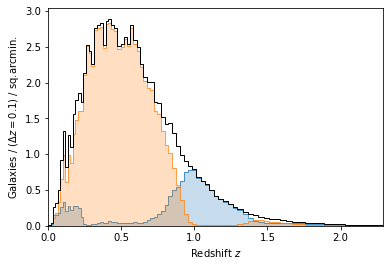

In [54]:
plot_dndz(dndz_bin, init_data[0])

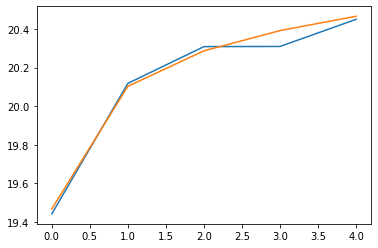

In [57]:
plt.plot(np.array(all_scores).T);

Epoch 1 train 51.066 validation 51.109.
Epoch 2 train 53.981 validation 54.023.
Epoch 3 train 54.821 validation 54.846.
Epoch 4 train 55.714 validation 55.754.
Epoch 5 train 56.280 validation 56.323.
Epoch 6 train 56.507 validation 56.523.
Epoch 7 train 56.670 validation 56.701.
Epoch 8 train 56.413 validation 56.444.
Epoch 9 train 56.821 validation 56.836.
Epoch 10 train 56.902 validation 56.908.
Epoch 11 train 56.902 validation 56.901.
Epoch 12 train 57.018 validation 57.056.
Epoch 13 train 57.018 validation 57.036.
Epoch 14 train 57.179 validation 57.187.
Epoch 15 train 57.167 validation 57.177.
Epoch 16 train 56.976 validation 56.945.
Epoch 17 train 57.215 validation 57.231.
Epoch 18 train 57.261 validation 57.256.
Epoch 19 train 57.120 validation 57.124.
Epoch 20 train 57.202 validation 57.214.
Epoch 21 train 57.157 validation 57.173.
Epoch 22 train 57.073 validation 57.063.
Epoch 23 train 57.277 validation 57.259.
Epoch 24 train 57.177 validation 57.187.
Epoch 25 train 57.254 val

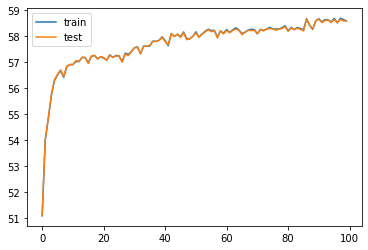

In [42]:
learn_nnet(nbin=4, nlayer=3)